# Introduction: (Business) Questions and methodology

In this jupyter notebook I aim to answer the following business questions:
- BQ1: Which city is more expensive: Seattle or Boston?
- BQ2: What influences the price?
- BQ3: Are there specific areas within the cities that are more expensive?

To do this I intend to follow the data science process:
1. Gather
2. Assess
3. Clean
4. Analyze
5. Model
6. Visualize


## Thoughts on how to answer BQ1
For this first question I want to compare the listings prices for the cities. That means that I will most likely only the the price column. But maybe I want to use some more information too.

## Thoughts on how to answer BQ2
Here, I want to find out which factors influence the listings for both cities. Thus it is time to get a more detailed look into the specific columns and to do some feature engineering. Before I get started I want to get an overview and choose columns of interest. When I have found them I will perform the following steps for both cities (since I want to use the same set of columns I need to assess those only once):
- Clean the data
    - Remove NaN entries from the data sets. I could impute missing values but I think that this would, in this case, blurr the results. Also I checked the columns beforehand for a percentage of NaN values and exclude those from my considerations which already had a NaN proportion of more than 30 percent. So I assured that I wont lose to much information
    - Transform non-numeric columns to binary dummie variables (every column can be only 1 or 0). This approach has the advantage that it is very straightforward, that I dont lose to much information and correlation analysis is quite easy.
- Build a first multivariate linear regression model and calculate RMSE and R2-score. Although there are models that are more interesting and potentially perform better linear models (LM) are a great starting point. They are intuitive to understand and perform also with small sample size (roughly 3500 or 3800 are in my opinion a small sample size). R2 and RMSE are standard measures for regression. I could also use MSE instead of RMSE but I personally like RMSE more since the difference it expresses is more relatible to the values of the dependent variable
- After I built the first LM I want to perform a correlation analysis. for this I use the build in correlation function of pandas and I use the default figure, the Pearson Correlation Coefficient (PCC)
- Based on this analysis I want to keep all features that have a PCC of >0.1 or <-0.1 and drop the rest
- Then I want to train another LM to see wether the measures improved or not

## Thoughts on how to answer BQ3
To find out if the are specific areas within the cities that drive the price towards a certain direction I want to plot them on the maps of Boston and Seattle. First, I want to plot the listings colored by price values to see if I already can draw some conclusion from this. Second, I want to colorize the listing by the correlation of their ZIP codes and their prices. Since I have already done, gathering, assessment, cleaning and analysis I will only perform the visualization steps for Boston and Seattle.

# Before we get started

### Import the packages that are needed
First we need to import the needed packages. The can be grouped like this:
- General functionality: Used for wrangling data and basic text/math operation
- Plotting/visualization
- Machine learning modules: Used to build and assess models 

In [1]:
# general functionality
import pandas as pd
import numpy as np
import math as mt
import re

# plotting
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors

# machine learning modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Write the functions that we want to use

In [2]:
def price_string_to_float(price_string):
    
    """
    Transforms string input to float.
    
    Parameters:
    String that contains price
    
    Returns:
    Price as float
    
    """
    
    price_float = float(re.findall("\d+\.\d+", price_string)[0])
    
    return price_float

# 1 Gather Data
- Here I choose, not to use the calendar and reviews data sets. I checked the calendar data and didnt find the informations too interesting. The reviews data, on the other hand, is very intersting but I didnt want to go into text analysis with this project
- Also that listings data sets contain many columns that can be used
- Latitude and Longitude caught my eye and therefore I wanted to use them for interesting plots. So I searched the internet for shp-files (which are also in this diretory)
- The Seattle shp-file can be found here: https://data-seattlecitygis.opendata.arcgis.com/
- The Boston shp-file can be found here: https://data.boston.gov/dataset/city-of-boston-boundary

In [3]:
# Listings data
b_df = pd.read_csv("b_listings.csv")
s_df = pd.read_csv("s_listings.csv")
# shapefile data
seattle = geopandas.read_file("./data/City_Clerk_Neighborhoods.shp")
seattle = seattle.to_crs(epsg=4326)
boston = geopandas.read_file("./data/City_of_Boston_Boundary.shp")
boston = boston.to_crs(epsg=4326)

# 2 Assess Data

First, get a general overview and then check out the price column which we will need to answer BQ1.

In [4]:
# I wanted to check out the dimensions of the data sets
# Both data sets have a similar number of samples but Seattle has two more columns
print(F"Boston Listings Shape: {b_df.shape}")
print(F"Seatle Listings Shape: {s_df.shape}")

Boston Listings Shape: (3585, 95)
Seatle Listings Shape: (3818, 92)


In [5]:
# print all the columns to get an overview for Boston
b_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [6]:
# print all the columns to get an overview for Seattle
s_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [7]:
# I created two lists containing just the column names
b_cols = b_df.columns
s_cols = s_df.columns

# And I created another list that contains the non matching columns and printed my result
non_matching_cols = [list(set(b_cols).difference(s_cols))]
print(non_matching_cols)

# I added a column for each city name 
# This ensure that I can differentiate between both when I merge the data
b_df["source_city"] = "Boston"
s_df["source_city"] = "Seattle"
listings_df = pd.concat([b_df, s_df])

# I printed the merged data to check if everything worked out as expected
print(listings_df.shape)

[['access', 'house_rules', 'interaction']]
(7403, 96)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [8]:
# Check out the price column since I want to use it to answer BQ1
listings_df["price"]

0       $250.00
1        $65.00
2        $65.00
3        $75.00
4        $79.00
         ...   
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 7403, dtype: object

Now, we know that we have to transform the price column in the cleaning step. But before we go to the next step. Let's check out the other columns in more detail to get a glimplse what could be of interest to answer BQ2.

In [9]:
# printing column + value for index = 0 to scan them manually before starting further analysis
for col in b_df.columns:
    print(F"{col}: {b_df[col][0]}")
    print(F"")

id: 12147973

listing_url: https://www.airbnb.com/rooms/12147973

scrape_id: 20160906204935

last_scraped: 2016-09-07

name: Sunny Bungalow in the City

summary: Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.

space: The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.

description: Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, bee

In [10]:
# Checking for columns with high NaN count (greater than 30 percent)
b_nas = pd.DataFrame(b_df.apply(lambda x: x.isna().sum()), columns=["count"]).sort_values(by="count", ascending=False)
b_nas["na_percentage"] = b_nas["count"].apply(lambda x: x/b_df.shape[0])
b_nas = b_nas.loc[b_nas["na_percentage"] >= 0.3]

# Print and overview of columns that arent useful because they have too many NaN values
b_nas

,count,na_percentage
neighbourhood_group_cleansed,3585,1.000000
has_availability,3585,1.000000
jurisdiction_names,3585,1.000000
license,3585,1.000000
square_feet,3529,0.984379
monthly_price,2697,0.752301
weekly_price,2693,0.751185
security_deposit,2243,0.625662
notes,1975,0.550907
interaction,1554,0.433473


In [11]:
# from the manual check of the columns above I chose the columns below to be potentially useful
# create a list with columns of interest
columns_of_interest = [
"id",
"latitude",
"longitude",
"price",
"zipcode",
"bathrooms",
"bedrooms",
"beds",
"bed_type",
"cancellation_policy",
"amenities",
"guests_included",
"instant_bookable",
"host_has_profile_pic",
"host_verifications",
"number_of_reviews",
"host_listings_count",
"host_total_listings_count",
"host_identity_verified",
"review_scores_accuracy",
"review_scores_location",
"review_scores_value",
"review_scores_checkin",
"review_scores_communication",
"review_scores_cleanliness",
"review_scores_rating",
"reviews_per_month",
]

# 3 Clean Data
Since I found out that the price column needs to be cleaned, I want to transform it to float


In [12]:
# The price entry contained a dollar sign which showed that it has to be transformed to a float
# I used a regex that only matches numbers and one dot between and printed my result to see if it worked
listings_df["price"] = listings_df["price"].apply(price_string_to_float)
# Also apply the same function to b_df and s_df
b_df["price"] = b_df["price"].apply(price_string_to_float)
s_df["price"] = s_df["price"].apply(price_string_to_float)
listings_df["price"].head(3)

0    250.0
1     65.0
2     65.0
Name: price, dtype: float64

Now let's clean the other columns that I plan to use to answer BQ2 and BQ3. 

In [13]:
# Cleaning df from na values in columns of interest
# Printing shape before and after cleaning to see how much information got lost
print(b_df.shape[0])
b_df_cleaned = b_df[columns_of_interest].dropna()
print(b_df_cleaned.shape[0])
b_df_cleaned = b_df_cleaned.reset_index()

3585
2712


### Boston
First, I want to clean the Boston df.

In [14]:
# No I have to check which columns have to be transformed to dummy columns
# checking df for different datatypes
b_df = b_df[columns_of_interest]

for col in b_df.columns:
    if(b_df[col].dtype == "object"):
        print(col)

zipcode
bed_type
cancellation_policy
amenities
instant_bookable
host_has_profile_pic
host_verifications
host_identity_verified


In [15]:
# Checking non-numeric columns for unique features
b_df_features = b_df_cleaned[b_df_cleaned.columns.difference(["index", "id", "latitude", "longitude"])]

for col in b_df_features:
    if(b_df_features[col].dtype == "object"):
        print(F"{col}: {len(set(b_df_features[col]))}")

amenities: 2395
bed_type: 5
cancellation_policy: 4
host_has_profile_pic: 2
host_identity_verified: 2
host_verifications: 52
instant_bookable: 2
zipcode: 40


In [16]:
# The amenities column looks weird let's print some value to see what's going on
b_df_features["amenities"]

0       {TV,Internet,"Wireless Internet","Air Conditio...
1       {TV,"Cable TV","Wireless Internet","Air Condit...
2       {Internet,"Wireless Internet","Air Conditionin...
3       {"Cable TV","Wireless Internet","Air Condition...
4       {TV,Internet,"Wireless Internet",Kitchen,"Free...
                              ...                        
2707    {"Wireless Internet",Kitchen,"Free Parking on ...
2708    {Internet,"Wireless Internet","Air Conditionin...
2709    {TV,Internet,"Wireless Internet","Air Conditio...
2710    {Internet,"Wireless Internet","Air Conditionin...
2711    {Kitchen,Gym,"Family/Kid Friendly",Washer,Drye...
Name: amenities, Length: 2712, dtype: object

In [17]:
# It appears that each amenities entry is a set of single values saved as a string
# We want to go through each entry and add them to a list to get each possible value
# print unique entries in amnities column
amnity_list = []

for i in range(0, b_df_features.shape[0]):
    amnity_row = b_df_features["amenities"][i].split(",")
    for element in amnity_row:
        element = element.replace('"', '').replace('{', '').replace('}', '')
        amnity_list.append(element)


# Transform the list to a set
amnity_set = set(amnity_list)

# Print length and every entry
print(len(amnity_set))
for entry in amnity_set:
      print(entry)

46

24-Hour Check-in
Cable TV
Laptop Friendly Workspace
Hot Tub
TV
Lock on Bedroom Door
Cat(s)
Paid Parking Off Premises
Dog(s)
Other pet(s)
Shampoo
Elevator in Building
Essentials
Gym
Indoor Fireplace
Kitchen
Washer
Breakfast
Wheelchair Accessible
Pets Allowed
translation missing: en.hosting_amenity_49
Pets live on this property
Buzzer/Wireless Intercom
Pool
Free Parking on Street
Fire Extinguisher
Free Parking on Premises
Doorman
Internet
Carbon Monoxide Detector
translation missing: en.hosting_amenity_50
Dryer
Washer / Dryer
Iron
Smoking Allowed
Smoke Detector
Heating
Suitable for Events
Wireless Internet
Air Conditioning
Safety Card
Family/Kid Friendly
Hangers
Hair Dryer
First Aid Kit


In [18]:
# Above are 3 entries that dont make sense
# "", "translation missing: en.hosting_amenity_49" and "translation missing: en.hosting_amenity_50"
# Remove them and print set length and the entries to see if it worked

amnity_set.remove("")
amnity_set.remove("translation missing: en.hosting_amenity_49")
amnity_set.remove("translation missing: en.hosting_amenity_50")

print(len(amnity_set))

for entry in amnity_set:
      print(entry)

43
24-Hour Check-in
Cable TV
Laptop Friendly Workspace
Hot Tub
TV
Lock on Bedroom Door
Cat(s)
Paid Parking Off Premises
Dog(s)
Other pet(s)
Shampoo
Elevator in Building
Essentials
Gym
Indoor Fireplace
Kitchen
Washer
Breakfast
Wheelchair Accessible
Pets Allowed
Pets live on this property
Buzzer/Wireless Intercom
Pool
Free Parking on Street
Fire Extinguisher
Free Parking on Premises
Doorman
Internet
Carbon Monoxide Detector
Dryer
Washer / Dryer
Iron
Smoking Allowed
Smoke Detector
Heating
Suitable for Events
Wireless Internet
Air Conditioning
Safety Card
Family/Kid Friendly
Hangers
Hair Dryer
First Aid Kit


In [19]:
# For all the following columns I do the same that I have done with amenities
# print unique entries in bed_type column
bed_type_set = set( b_df_features["bed_type"])

print(len(bed_type_set))

for entry in bed_type_set:
      print(entry)

5
Pull-out Sofa
Airbed
Couch
Futon
Real Bed


In [20]:
# print unique entries in cancellation_policy column
cancellation_policy_set = set( b_df_features["cancellation_policy"])

print(len(cancellation_policy_set))

for entry in cancellation_policy_set:
      print(entry)

4
moderate
strict
flexible
super_strict_30


In [21]:
# print unique entries in host_has_profile_pic column
host_has_profile_pic_set = set( b_df_features["host_has_profile_pic"])

print(len(host_has_profile_pic_set))

for entry in host_has_profile_pic_set:
      print(entry)

2
t
f


In [22]:
# print unique entries in host_identity_verified column
host_identity_verified_set = set( b_df_features["host_identity_verified"])

print(len(host_identity_verified_set))

for entry in host_identity_verified_set:
      print(entry)

2
t
f


In [23]:
# print unique entries in instant_bookable column
instant_bookable_set = set( b_df_features["instant_bookable"])

print(len(instant_bookable_set))

for entry in instant_bookable_set:
      print(entry)

2
t
f


In [24]:
# print unique entries in host_verification column
host_verifications_list = []

for i in range(0, b_df_features.shape[0]):
    host_verifications_row = b_df_features["host_verifications"][i].split(",")
    for element in host_verifications_row:
        element = element.replace('[', '').replace(']', '').replace("'", '').strip()
        host_verifications_list.append(element)
        
host_verifications_set = set(host_verifications_list)

print(len(host_verifications_set))

for entry in host_verifications_set:
      print(entry)

13
kba
google
phone
sent_id
linkedin
weibo
manual_online
jumio
facebook
manual_offline
email
reviews
amex


In [25]:
# print unique entries in zipcode column
zip_code_set = set( b_df_features["zipcode"])

print(len(zip_code_set))

for entry in zip_code_set:
      print(entry)

40
02111
02108
02122
02109
02131
02467
02116
02134
02113
02130
02186
02129
02446
02125
02121
02136
02110
02139
02142
02163
02120
02126
02445
02135
02127
02118
02145
02124
02134-1704
02128
02114
02215
02115
02108 02111
02141
02119
02138
02143
02210
02132


In [26]:
# get all numeric columns and append them to a list
#num_cols = []

#for col in b_df_features.columns:
#    if(b_df_features[col].dtype == "object"):
#        continue
#    else:
#        print(b_df_features[col].dtype)
#        num_cols.append(col)

In [27]:
# create dummie variables for the chosen non numeric columns and fill them with 0
for element in list(amnity_set):
    b_df_features[F"amnity_{element}"] = 0
    
for element in list(host_verifications_set):
    b_df_features[F"hv_{element}"] = 0
    
for element in list(zip_code_set):
    b_df_features[F"zipcode_{element}"] = 0

for element in list(bed_type_set):
    b_df_features[F"bt_{element}"] = 0
    
for element in list(cancellation_policy_set):
    b_df_features[F"cp_{element}"] = 0
    
for element in list(host_has_profile_pic_set):
    b_df_features[F"hpc_{element}"] = 0
    
for element in list(host_identity_verified_set):
    b_df_features[F"hiv_{element}"] = 0
    
for element in list(instant_bookable_set):
    b_df_features[F"ib_{element}"] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# go over dummy columns and fill with 1 if the value is found in the original column
# This could take a while since my implementation may be not the fastest
for col in b_df_features.iloc[:, 24:]:
    
    if "amnity" in col: 
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[7:] in b_df_features["amenities"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
    elif "zipcode" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[8:] in b_df_features["zipcode"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                
    elif "hv_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["host_verifications"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                
    elif "bt_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["bed_type"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0                
                
    elif "cp_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["cancellation_policy"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0               
                
    elif "hpc_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[4:] in b_df_features["host_has_profile_pic"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                                
    elif "hiv_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[4:] in b_df_features["host_identity_verified"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0
                
    elif "ib_" in col:
        print(col)
        for i in range(0, b_df_features.shape[0]):
            if col[3:] in b_df_features["instant_bookable"][i]:
                b_df_features[col][i] = 1
            else:
                b_df_features[col][i] = 0

amnity_24-Hour Check-in


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


amnity_Cable TV
amnity_Laptop Friendly Workspace
amnity_Hot Tub
amnity_TV
amnity_Lock on Bedroom Door
amnity_Cat(s)
amnity_Paid Parking Off Premises
amnity_Dog(s)
amnity_Other pet(s)
amnity_Shampoo
amnity_Elevator in Building
amnity_Essentials
amnity_Gym
amnity_Indoor Fireplace
amnity_Kitchen
amnity_Washer
amnity_Breakfast
amnity_Wheelchair Accessible
amnity_Pets Allowed
amnity_Pets live on this property
amnity_Buzzer/Wireless Intercom
amnity_Pool
amnity_Free Parking on Street
amnity_Fire Extinguisher
amnity_Free Parking on Premises
amnity_Doorman
amnity_Internet
amnity_Carbon Monoxide Detector
amnity_Dryer
amnity_Washer / Dryer
amnity_Iron
amnity_Smoking Allowed
amnity_Smoke Detector
amnity_Heating
amnity_Suitable for Events
amnity_Wireless Internet
amnity_Air Conditioning
amnity_Safety Card
amnity_Family/Kid Friendly
amnity_Hangers
amnity_Hair Dryer
amnity_First Aid Kit
hv_kba


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hv_google
hv_phone
hv_sent_id
hv_linkedin
hv_weibo
hv_manual_online
hv_jumio
hv_facebook
hv_manual_offline
hv_email
hv_reviews
hv_amex
zipcode_02111


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


zipcode_02108
zipcode_02122
zipcode_02109
zipcode_02131
zipcode_02467
zipcode_02116
zipcode_02134
zipcode_02113
zipcode_02130
zipcode_02186
zipcode_02129
zipcode_02446
zipcode_02125
zipcode_02121
zipcode_02136
zipcode_02110
zipcode_02139
zipcode_02142
zipcode_02163
zipcode_02120
zipcode_02126
zipcode_02445
zipcode_02135
zipcode_02127
zipcode_02118
zipcode_02145
zipcode_02124
zipcode_02134-1704
zipcode_02128
zipcode_02114
zipcode_02215
zipcode_02115
zipcode_02108 02111
zipcode_02141
zipcode_02119
zipcode_02138
zipcode_02143
zipcode_02210
zipcode_02132
bt_Pull-out Sofa


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


bt_Airbed
bt_Couch
bt_Futon
bt_Real Bed
cp_moderate


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cp_strict
cp_flexible
cp_super_strict_30
hpc_t


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hpc_f
hiv_t


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hiv_f
ib_t


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ib_f


### Seattle
For Seattle I will shortcut some of the other steps since I can draw from the knowledge I gained from the steps I performed for Boston.



In [30]:
# Cleaning df from na values in columns of interest
# Printing shape before and after cleaning to see how much information got lost
print(s_df.shape[0])
s_df_cleaned = s_df[columns_of_interest].dropna()
print(s_df_cleaned.shape[0])
s_df_cleaned = s_df_cleaned.reset_index()

3818
3134


In [31]:
# Checking non-numeric columns for unique features
s_df_features = s_df_cleaned[s_df_cleaned.columns.difference(["index", "id", "latitude", "longitude"])]

for col in s_df_cleaned:
    if(s_df_cleaned[col].dtype == "object"):
        print(F"{col}: {len(set(s_df_cleaned[col]))}")

zipcode: 28
bed_type: 5
cancellation_policy: 3
amenities: 2705
instant_bookable: 2
host_has_profile_pic: 2
host_verifications: 80
host_identity_verified: 2


In [32]:
# print unique entries in amenities column
amnity_list = []

for i in range(0, s_df_features.shape[0]):
    amnity_row = s_df_features["amenities"][i].split(",")
    for element in amnity_row:
        element = element.replace('"', '').replace('{', '').replace('}', '')
        amnity_list.append(element)

amnity_set = set(amnity_list)
amnity_set.remove("")

print(len(amnity_set))

for entry in amnity_set:
      print(entry)

41
24-Hour Check-in
Cable TV
Laptop Friendly Workspace
Hot Tub
TV
Lock on Bedroom Door
Cat(s)
Dog(s)
Other pet(s)
Shampoo
Elevator in Building
Essentials
Gym
Indoor Fireplace
Kitchen
Washer
Breakfast
Wheelchair Accessible
Pets Allowed
Pets live on this property
Buzzer/Wireless Intercom
Pool
Free Parking on Premises
Fire Extinguisher
Doorman
Internet
Carbon Monoxide Detector
Dryer
Washer / Dryer
Iron
Smoking Allowed
Smoke Detector
Heating
Suitable for Events
Wireless Internet
Air Conditioning
Safety Card
Family/Kid Friendly
Hangers
Hair Dryer
First Aid Kit


In [33]:
# print unique entries in bed_type column
bed_type_set = set( s_df_features["bed_type"])

print(len(bed_type_set))

for entry in bed_type_set:
      print(entry)

5
Pull-out Sofa
Airbed
Couch
Futon
Real Bed


In [34]:
# print unique entries in cancellation_policy column
cancellation_policy_set = set( s_df_features["cancellation_policy"])

print(len(cancellation_policy_set))

for entry in cancellation_policy_set:
      print(entry)

3
moderate
flexible
strict


In [35]:
# print unique entries in host_has_profile_pic column
host_has_profile_pic_set = set( s_df_features["host_has_profile_pic"])

print(len(host_has_profile_pic_set))

for entry in host_has_profile_pic_set:
      print(entry)

2
t
f


In [36]:
# print unique entries in host_identity_verified column
host_identity_verified_set = set( s_df_features["host_identity_verified"])

print(len(host_identity_verified_set))

for entry in host_identity_verified_set:
      print(entry)

2
t
f


In [37]:
# print unique entries in instant_bookable column
instant_bookable_set = set( s_df_features["instant_bookable"])

print(len(instant_bookable_set))

for entry in instant_bookable_set:
      print(entry)

2
f
t


In [38]:
# print unique entries in host_verification column
host_verifications_list = []

for i in range(0, s_df_features.shape[0]):
    host_verifications_row = s_df_features["host_verifications"][i].split(",")
    for element in host_verifications_row:
        element = element.replace('[', '').replace(']', '').replace("'", '').strip()
        host_verifications_list.append(element)
        
host_verifications_set = set(host_verifications_list)

print(len(host_verifications_set))

for entry in host_verifications_set:
      print(entry)

14
kba
amex
google
phone
sent_id
linkedin
weibo
manual_online
facebook
manual_offline
email
reviews
jumio
photographer


In [39]:
# print unique entries in zipcode column
zip_code_set = set( s_df_features["zipcode"])

print(len(zip_code_set))

for entry in zip_code_set:
      print(entry)

28
98115
98104
98109
99
98122
98101
98118
98133
98178
98103
98112
98102
98126
98108
98116
98136
98199
98134
98117
98121
98144
98119
98125
98107
98122
98146
98105
98177
98106


In [40]:
# create dummy columns for non numeric columns

for element in list(amnity_set):
    s_df_features[F"amnity_{element}"] = 0
    
for element in list(host_verifications_set):
    s_df_features[F"hv_{element}"] = 0
    
for element in list(zip_code_set):
    s_df_features[F"zipcode_{element}"] = 0

for element in list(bed_type_set):
    s_df_features[F"bt_{element}"] = 0
    
for element in list(cancellation_policy_set):
    s_df_features[F"cp_{element}"] = 0
    
for element in list(host_has_profile_pic_set):
    s_df_features[F"hpc_{element}"] = 0
    
for element in list(host_identity_verified_set):
    s_df_features[F"hiv_{element}"] = 0
    
for element in list(instant_bookable_set):
    s_df_features[F"ib_{element}"] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [41]:
# For each new features column, write 1 if "original column" has entry, write 0 if not

for col in s_df_features.iloc[:, 24:]:
    
    if "amnity" in col: 
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[7:] in s_df_features["amenities"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
    elif "zipcode" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[8:] in s_df_features["zipcode"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                
    elif "hv_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["host_verifications"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                
    elif "bt_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["bed_type"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0                
                
    elif "cp_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["cancellation_policy"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0               
                
    elif "hpc_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[4:] in s_df_features["host_has_profile_pic"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                                
    elif "hiv_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[4:] in s_df_features["host_identity_verified"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0
                
    elif "ib_" in col:
        print(col)
        for i in range(0, s_df_features.shape[0]):
            if col[3:] in s_df_features["instant_bookable"][i]:
                s_df_features[col][i] = 1
            else:
                s_df_features[col][i] = 0

amnity_24-Hour Check-in


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


amnity_Cable TV
amnity_Laptop Friendly Workspace
amnity_Hot Tub
amnity_TV
amnity_Lock on Bedroom Door
amnity_Cat(s)
amnity_Dog(s)
amnity_Other pet(s)
amnity_Shampoo
amnity_Elevator in Building
amnity_Essentials
amnity_Gym
amnity_Indoor Fireplace
amnity_Kitchen
amnity_Washer
amnity_Breakfast
amnity_Wheelchair Accessible
amnity_Pets Allowed
amnity_Pets live on this property
amnity_Buzzer/Wireless Intercom
amnity_Pool
amnity_Free Parking on Premises
amnity_Fire Extinguisher
amnity_Doorman
amnity_Internet
amnity_Carbon Monoxide Detector
amnity_Dryer
amnity_Washer / Dryer
amnity_Iron
amnity_Smoking Allowed
amnity_Smoke Detector
amnity_Heating
amnity_Suitable for Events
amnity_Wireless Internet
amnity_Air Conditioning
amnity_Safety Card
amnity_Family/Kid Friendly
amnity_Hangers
amnity_Hair Dryer
amnity_First Aid Kit
hv_kba


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hv_amex
hv_google
hv_phone
hv_sent_id
hv_linkedin
hv_weibo
hv_manual_online
hv_facebook
hv_manual_offline
hv_email
hv_reviews
hv_jumio
hv_photographer
zipcode_98115


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


zipcode_98104
zipcode_98109
zipcode_99
98122
zipcode_98101
zipcode_98118
zipcode_98133
zipcode_98178
zipcode_98103
zipcode_98112
zipcode_98102
zipcode_98126
zipcode_98108
zipcode_98116
zipcode_98136
zipcode_98199
zipcode_98134
zipcode_98117
zipcode_98121
zipcode_98144
zipcode_98119
zipcode_98125
zipcode_98107
zipcode_98122
zipcode_98146
zipcode_98105
zipcode_98177
zipcode_98106
bt_Pull-out Sofa


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


bt_Airbed
bt_Couch
bt_Futon
bt_Real Bed
cp_moderate


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cp_flexible
cp_strict
hpc_t


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hpc_f
hiv_t


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


hiv_f
ib_f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ib_t


# 4 Analyze Data

Since price is a numeric column I want to calculate the mean as well as the median to answer BQ1.

In [42]:
b_median = listings_df.loc[listings_df["city"] == "Boston"]["price"].median()
b_mean = listings_df.loc[listings_df["city"] == "Boston"]["price"].mean()
print(F"Boston (median) {b_median}")
print(F"Boston (mean) {b_mean}")

Boston (median) 150.0
Boston (mean) 172.05678793256433


In [43]:
s_median = listings_df.loc[listings_df["city"] == "Seattle"]["price"].median()
s_mean = listings_df.loc[listings_df["city"] == "Seattle"]["price"].mean()
print(F"Seattle (median) {s_median}")
print(F"Seattle (mean) {s_mean}")

Seattle (median) 100.0
Seattle (mean) 127.78976377952756


Both measures indicate that the answer to BQ1 is "Boston". But it would be useful to visualize the results later.

# 5 Model Data
Now we will choose only the numeric data and build the models starting with Boston

### Boston

In [44]:
# choose only numeric columns to add them to the data that is used for training
nums = []

for col in b_df_features.columns:
    if(b_df_features[col].dtype == "object"):
        continue
    else:
        nums.append(col)

In [45]:
# Choose only numeric values
b_df_features_numeric = b_df_features[nums]
b_df_features_numeric

,bathrooms,bedrooms,beds,guests_included,host_listings_count,host_total_listings_count,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,...,cp_moderate,cp_strict,cp_flexible,cp_super_strict_30,hpc_t,hpc_f,hiv_t,hiv_f,ib_t,ib_f
0,1.0,1.0,1.0,0,1,1,36,65.0,10.0,10.0,...,1,0,0,0,1,0,1,0,1,0
1,1.0,1.0,1.0,1,1,1,41,65.0,10.0,10.0,...,1,0,0,0,1,0,1,0,0,1
2,1.5,1.0,2.0,1,1,1,29,79.0,10.0,10.0,...,0,0,1,0,1,0,1,0,0,1
3,1.0,1.0,1.0,1,2,2,8,75.0,10.0,10.0,...,0,0,1,0,1,0,1,0,0,1
4,1.0,1.0,2.0,1,5,5,57,100.0,10.0,10.0,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,1.0,1.0,1.0,1,2,2,1,68.0,8.0,8.0,...,1,0,0,0,1,0,0,1,0,1
2708,1.0,1.0,1.0,1,28,28,6,69.0,8.0,9.0,...,0,1,0,0,1,0,1,0,1,0
2709,1.0,1.0,1.0,1,4,4,2,85.0,10.0,10.0,...,0,1,0,0,1,0,0,1,1,0
2710,1.0,1.0,1.0,1,28,28,4,69.0,10.0,10.0,...,0,1,0,0,1,0,1,0,1,0


In [46]:
#Split into explanatory and response variables
X = b_df_features_numeric.loc[:, b_df_features_numeric.columns != 'price']
y = b_df_features_numeric['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.6280109430696319
64.7370591982653


In [47]:
# create df with correlations with price
price_correlation = pd.DataFrame(b_df_features_numeric.corr()["price"])

In [48]:
# check for features with a positive correlation with a PCC greater than 0.1
positive_correlation = []

positive_correlation_values = []

for i in price_correlation.index.tolist():
    if(price_correlation["price"][i] > 0.1):
        positive_correlation.append(i)
        positive_correlation_values.append(price_correlation["price"][i])
print(positive_correlation)

# Create a df with positive features and values
positive_correlation_df = pd.DataFrame({'feature': positive_correlation,'corr': positive_correlation_values}).sort_values(by="corr", ascending=False)

['bathrooms', 'bedrooms', 'beds', 'guests_included', 'host_listings_count', 'host_total_listings_count', 'price', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_rating', 'amnity_24-Hour Check-in', 'amnity_Cable TV', 'amnity_TV', 'amnity_Elevator in Building', 'amnity_Gym', 'amnity_Indoor Fireplace', 'amnity_Kitchen', 'amnity_Washer', 'amnity_Buzzer/Wireless Intercom', 'amnity_Pool', 'amnity_Doorman', 'amnity_Dryer', 'amnity_Iron', 'amnity_Air Conditioning', 'amnity_Family/Kid Friendly', 'amnity_Hair Dryer', 'hv_manual_online', 'hv_manual_offline', 'zipcode_02111', 'zipcode_02116', 'zipcode_02118', 'zipcode_02114', 'zipcode_02210', 'bt_Real Bed', 'cp_strict', 'cp_super_strict_30']


In [49]:
# check for features with a negative correlation with a PCC smaller than -0.1
negative_correlation =  []

negative_correlation_values = []

for i in price_correlation.index.tolist():
    if(price_correlation["price"][i] < -0.1):
        negative_correlation.append(i)
        negative_correlation_values.append(price_correlation["price"][i])
print(negative_correlation)

# Create a df with positive features and values
negative_correlation_df = pd.DataFrame({'feature': negative_correlation,'corr': negative_correlation_values}).sort_values(by="corr", ascending=True)

['number_of_reviews', 'reviews_per_month', 'amnity_Lock on Bedroom Door', 'amnity_Cat(s)', 'amnity_Free Parking on Premises', 'zipcode_02134', 'zipcode_02125', 'zipcode_02135', 'zipcode_02124', 'bt_Futon', 'cp_flexible']


In [50]:
# Combine both lists of features that we want to keep
new_features = positive_correlation + negative_correlation
len(new_features)

47

In [51]:
# Create new df with reduced features
b_df_reduced_features = b_df_features_numeric[new_features]
b_df_reduced_features

,bathrooms,bedrooms,beds,guests_included,host_listings_count,host_total_listings_count,price,review_scores_cleanliness,review_scores_location,review_scores_rating,...,reviews_per_month,amnity_Lock on Bedroom Door,amnity_Cat(s),amnity_Free Parking on Premises,zipcode_02134,zipcode_02125,zipcode_02135,zipcode_02124,bt_Futon,cp_flexible
0,1.0,1.0,1.0,0,1,1,65.0,9.0,9.0,94.0,...,1.30,1,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1,1,1,65.0,9.0,9.0,98.0,...,0.47,1,0,1,0,0,0,0,0,0
2,1.5,1.0,2.0,1,1,1,79.0,10.0,9.0,99.0,...,2.25,0,0,0,0,0,0,0,0,1
3,1.0,1.0,1.0,1,2,2,75.0,10.0,9.0,100.0,...,1.70,0,1,1,0,0,0,0,0,1
4,1.0,1.0,2.0,1,5,5,100.0,10.0,9.0,90.0,...,4.00,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,1.0,1.0,1.0,1,2,2,68.0,8.0,10.0,80.0,...,1.00,0,0,1,0,0,0,0,0,0
2708,1.0,1.0,1.0,1,28,28,69.0,7.0,8.0,70.0,...,0.33,1,0,1,0,0,0,0,0,0
2709,1.0,1.0,1.0,1,4,4,85.0,10.0,10.0,100.0,...,2.00,0,0,0,0,0,0,0,0,0
2710,1.0,1.0,1.0,1,28,28,69.0,10.0,8.0,90.0,...,0.34,1,0,1,0,0,0,0,0,0


In [52]:
#Split into explanatory and response variables
X = b_df_reduced_features.loc[:, b_df_reduced_features.columns != 'price']
y = b_df_reduced_features['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.5947521157130891
67.56912000966678


Both R2 score and RMSE got worse. More feature engineering would be useful in future projects. But for now it is ok. 

### Seattle

In [53]:
# Keep only columns that are numeric
nums = []

for col in s_df_features.columns:
    if(s_df_features[col].dtype == "object"):
        continue
    else:
        nums.append(col)
        
s_df_features_numeric = s_df_features[nums]

In [54]:
#Split into explanatory and response variables
X = s_df_features_numeric.loc[:, s_df_features_numeric.columns != 'price']
y = s_df_features_numeric['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.5779545785740411
43.96274479529578


In [55]:
# Get columns with correlation >0.1 or <-0.1

price_correlation_seattle = pd.DataFrame(s_df_features_numeric.corr()["price"])

positive_correlation_seattle = []
positive_correlation_seattle_value = []
for i in price_correlation_seattle.index.tolist():
    if(price_correlation_seattle["price"][i] > 0.1):
        positive_correlation_seattle_value.append(price_correlation_seattle["price"][i])
        positive_correlation_seattle.append(i)

negative_correlation_seattle  =  []
negative_correlation_seattle_value = []
for i in price_correlation_seattle.index.tolist():
    if(price_correlation_seattle["price"][i] < -0.1):
        negative_correlation_seattle_value.append(price_correlation_seattle["price"][i])
        negative_correlation_seattle.append(i)

# Create dfs for later visualization
positive_correlation_seattle_df = pd.DataFrame({'feature': positive_correlation_seattle,'corr': positive_correlation_seattle_value}).sort_values(by="corr", ascending=False)
negative_correlation_seattle_df = pd.DataFrame({'feature': negative_correlation_seattle,'corr': negative_correlation_seattle_value}).sort_values(by="corr", ascending=False)

In [56]:
# Merge the lists with positive or negative correlation
new_features = positive_correlation_seattle + negative_correlation_seattle
len(new_features)

28

In [57]:
# Testing with reduced features
s_df_reduced_features = s_df_features_numeric[new_features]
s_df_reduced_features

#Split into explanatory and response variables
X = s_df_reduced_features.loc[:, s_df_reduced_features.columns != 'price']
y = s_df_reduced_features['price']
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=90) 
# Fit model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
# Predict data
y_test_preds = lm_model.predict(X_test) 
# Score predictions
y_test_preds = lm_model.predict(X_test)
r2_test = r2_score(y_test, y_test_preds) 
print(r2_test)
rmse_test = mt.sqrt(mean_squared_error(y_test, y_test_preds))
print(rmse_test)

0.5415405803972386
45.8200599561828


So far we gained some interesting insights. Now we will visualize our results to communicate them effectively.

# 6 Visualize Data

## BQ1: Which city is more expensive?

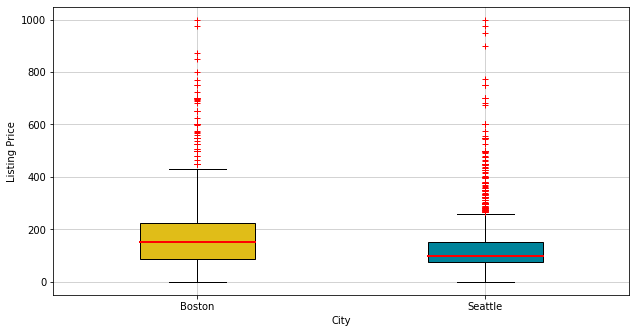

In [58]:
# Create box plots grouped by city
fig = plt.figure(figsize =(4, 4)) 
ax = fig.add_axes([0, 0, 2, 1]) 

# Create lists from the prices for Boston and Seattle
d1 =  listings_df.loc[listings_df["city"] == "Boston"]["price"].tolist()
d2 = listings_df.loc[listings_df["city"] == "Seattle"]["price"].tolist()

medianprops = dict(linestyle='-', linewidth=2, color='r')
bp0 = ax.boxplot(d1, positions=[0.25], sym='r+', notch=False, showfliers=True, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 
bp1 = ax.boxplot(d2, positions=[0.75], sym='r+', notch=False, showfliers=True, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 

# Colorize the boxes by the chosen color for the cities
for box in bp0['boxes']:
    box.set(facecolor = "#E0BD18")
for box in bp1['boxes']:
    box.set(facecolor = "#00839A" )

# Add some labels  and costumize the grid
plt.xlabel("City")
plt.ylabel("Listing Price")
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_xticklabels(["Boston", "Seattle"])
ax.set_facecolor("white")
plt.xlim(0, 1)
plt.savefig('price_comparison.png')

Ok, there are many outliers that blurr the plot. For this reason I want to plot the prices again, but without outliers.

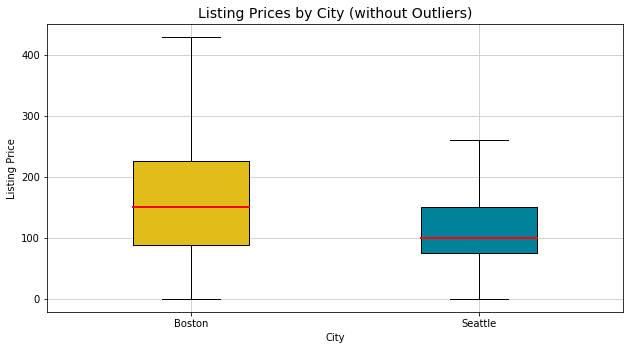

In [59]:
# Create box plots grouped by city (without outliers)

fig = plt.figure(figsize =(4, 4)) 
ax = fig.add_axes([0, 0, 2, 1]) 

# Create lists from the prices for Boston and Seattle
d1 =  listings_df.loc[listings_df["city"] == "Boston"]["price"].tolist()
d2 = listings_df.loc[listings_df["city"] == "Seattle"]["price"].tolist()

# Colorize the boxes by the chosen color for the cities
medianprops = dict(linestyle='-', linewidth=2, color='r')
bp0 = ax.boxplot(d1, positions=[0.25], notch=False, showfliers=False, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 
bp1 = ax.boxplot(d2, positions=[0.75], notch=False, showfliers=False, showbox=True, showcaps=True, widths = 0.2, patch_artist=True, medianprops=medianprops) 

for box in bp0['boxes']:
    box.set(facecolor = "#E0BD18")
for box in bp1['boxes']:
    box.set(facecolor = "#00839A" )

# Add some labels  and costumize the grids
plt.xlabel("City")
plt.ylabel("Listing Price")
plt.title("Listing Prices by City (without Outliers)", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_xticklabels(["Boston", "Seattle"])
ax.set_facecolor("white")
plt.xlim(0, 1)
plt.savefig('price_comparison_wo_outliers.png')


It seems that according to this plot and the measures I calculated above, that Boston indeed is more expensive. But I want to see how the comparision would look like if I grouped the listings by its ZIP codes

In [60]:
# Group average price by zip code and print results to see if it worked
zip_average_price = pd.DataFrame(listings_df.groupby('zipcode')['price'].mean()).sort_values(by='price', ascending=False)
zip_average_price["zipcode"] = zip_average_price.index
zip_average_price

,price,zipcode
zipcode,,
02108 02111,334.000000,02108 02111
02110,274.076923,02110
02142,270.000000,02142
02210,260.106667,02210
02111,253.535354,02111
...,...,...
02134-1704,80.000000,02134-1704
99\n98122,67.000000,99\n98122
02472,60.000000,02472


In [61]:
# The new df misses a city column
# So I create a city column and use fill it based on the zip code values
zip_average_price["city"] = zip_average_price["zipcode"].apply(lambda x: "Boston" if x.startswith("0") == True else "Seattle")

# Check if the grouping worked properly
set(zip_average_price["city"])

{'Boston', 'Seattle'}

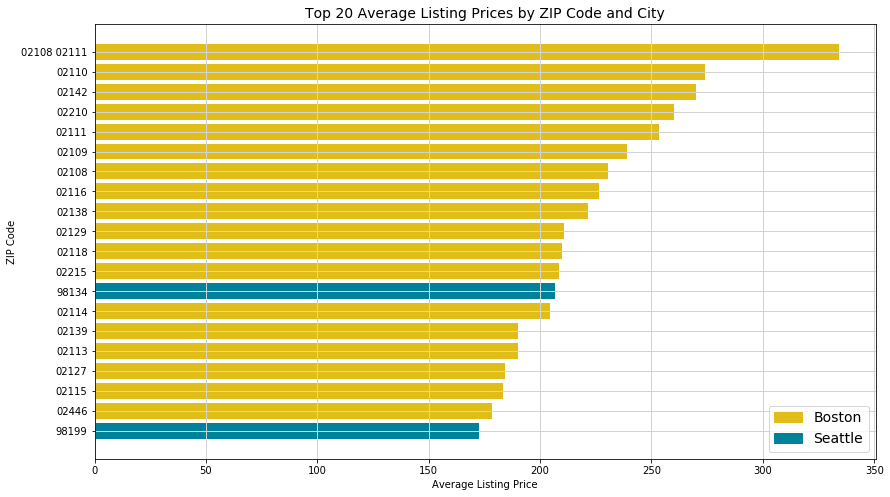

In [62]:
# Plot average prices by zip code and use the colors I chose for the cities
colors = {"Boston": '#E0BD18', "Seattle": '#00839A'}

fig, ax = plt.subplots(figsize=(14, 8))
fig = plt.barh(zip_average_price["zipcode"].head(20), zip_average_price["price"].head(20) , color=[colors[i] for i in zip_average_price['city']])
plt.xlabel("Average Listing Price")
plt.ylabel("ZIP Code")
plt.title("Top 20 Average Listing Prices by ZIP Code and City", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
ax.invert_yaxis()
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, fontsize=14)

plt.show()


## BQ2: What influences the price?

### Correlation Plot: Boston

In [63]:
# Create a df to plot the correlating features
# I excluded the columns with the highest correlation as this is price itself 
boston_corr_df = pd.concat([negative_correlation_df.head(10).reset_index(), positive_correlation_df.reset_index()[1:11]])
boston_corr_df = boston_corr_df.sort_values(by="corr", ascending=False)
boston_corr_df.index = boston_corr_df["feature"]
boston_corr_df = boston_corr_df[["corr"]]

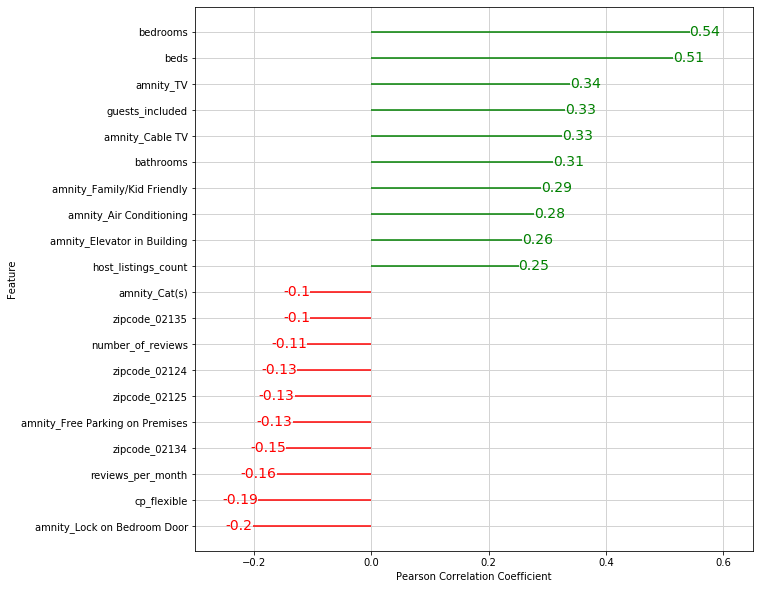

In [64]:
# Plot top correlation features

# Colorize red for negative and green for positive correlation
boston_corr_df['colors'] = ['red' if x < 0 else 'green' for x in boston_corr_df['corr']]

fig, ax = plt.subplots(figsize=(10, 10))
ax.invert_yaxis()

ax.hlines(y=boston_corr_df.index, xmin=0, xmax=boston_corr_df["corr"], color=boston_corr_df["colors"])
for x, y, tex in zip(boston_corr_df["corr"], boston_corr_df.index, boston_corr_df["corr"]):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})

plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Feature")
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
plt.xlim(-0.3, 0.65)
plt.savefig('boston_feature_correlation.png', bbox_inches='tight')

### Correlation Plot: Seattle

In [65]:
# create a df with all most correlation features 
seattle_corr_df = pd.concat([negative_correlation_seattle_df.head(10).reset_index(), positive_correlation_seattle_df.reset_index()[1:11]])
seattle_corr_df = seattle_corr_df.sort_values(by="corr", ascending=False)
seattle_corr_df.index = seattle_corr_df["feature"]
seattle_corr_df = seattle_corr_df[["corr"]]

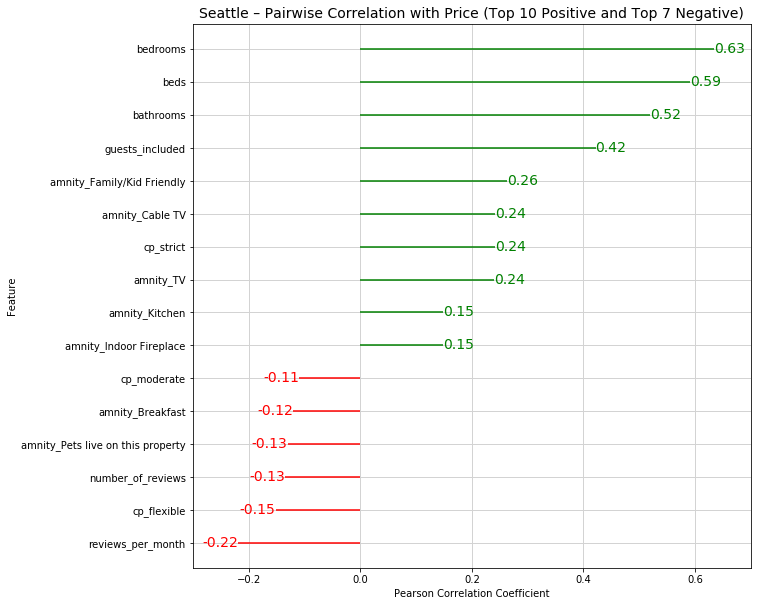

In [66]:
# Plot top correlation features

# Red for negative, green for negative
seattle_corr_df['colors'] = ['red' if x < 0 else 'green' for x in seattle_corr_df['corr']]

fig, ax = plt.subplots(figsize=(10, 10))
ax.invert_yaxis()

ax.hlines(y=seattle_corr_df.index, xmin=0, xmax=seattle_corr_df["corr"], color=seattle_corr_df["colors"])
for x, y, tex in zip(seattle_corr_df["corr"], seattle_corr_df.index, seattle_corr_df["corr"]):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})

plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Feature")
plt.title("Seattle – Pairwise Correlation with Price (Top 10 Positive and Top 7 Negative)", fontsize=14) 
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
plt.xlim(-0.3, 0.7)

plt.savefig('seattle_feature_correlation.png', bbox_inches='tight')

## BQ3: Are there specific areas within the cities that are more expensive?

### Boston

In [67]:
# get zips that correlate positively and print them
positive_correlation_zips = []
for element in positive_correlation:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        positive_correlation_zips.append(zipcode)
        
print(positive_correlation_zips)

['02111', '02116', '02118', '02114', '02210']


In [68]:
# get zips that correlate negatively and print them
negative_correlation_zips = []
for element in negative_correlation:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        negative_correlation_zips.append(zipcode)
        
print(negative_correlation_zips)
        
# Merge 
correlation_zips = positive_correlation_zips + negative_correlation_zips

['02134', '02125', '02135', '02124']


In [69]:
# Show counted values per zip code
print(b_df.shape[0])

# Drop rows that have no zip code
b_df_corr_zips = b_df.dropna(subset=['zipcode']).reset_index()

# Print again to see how many listings we lost
print(b_df_corr_zips.shape[0])

3585
3547


In [70]:
# Create correlation columns 
b_df_corr_zips["correlation"] = None

# Write value based correlating zip codes
for i in range(0, b_df_corr_zips.shape[0]):
    if(b_df_corr_zips['zipcode'][i] in positive_correlation_zips):
        b_df_corr_zips["correlation"][i] = "positive"
    elif(b_df_corr_zips['zipcode'][i] in negative_correlation_zips):
        b_df_corr_zips["correlation"][i] = "negative"
    else:
        b_df_corr_zips["correlation"][i] = "no correlation"

# Print unique values counts for value to check if everything worked as expected
print(b_df_corr_zips["correlation"].value_counts())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


no correlation    1894
positive          1040
negative           613
Name: correlation, dtype: int64


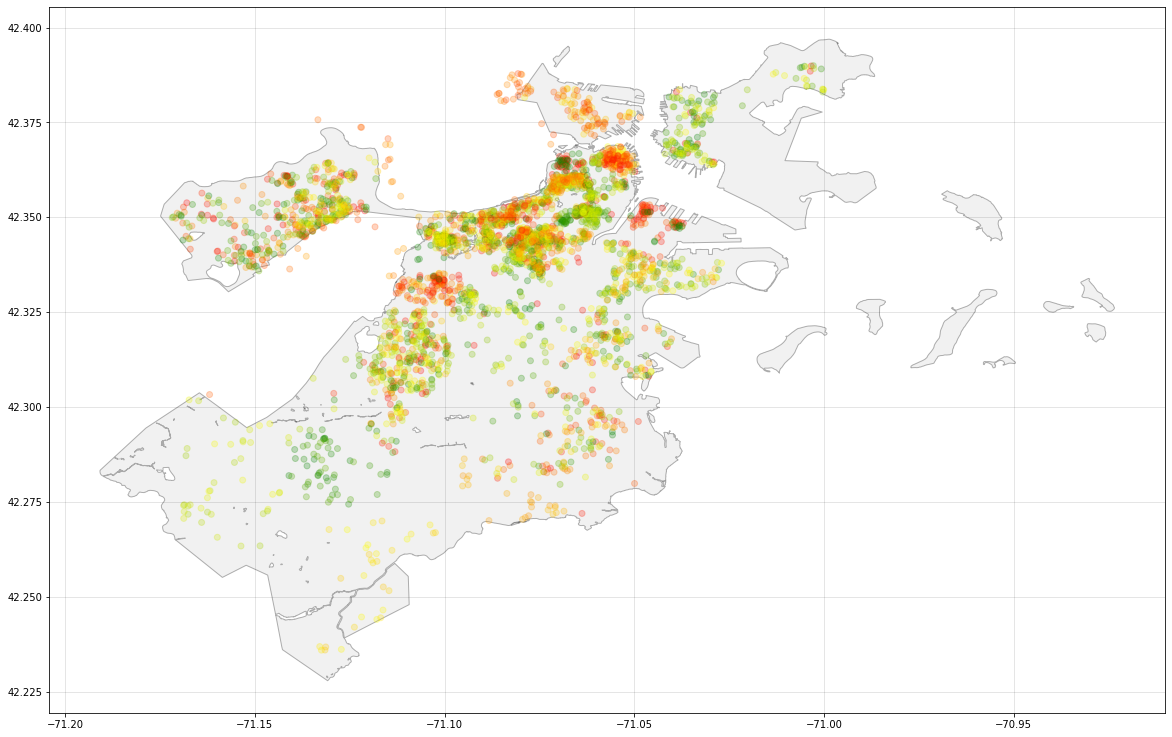

In [71]:
# Create df that only cointains the columns that we want to use
b_geo = b_df_corr_zips[["id", "price", "latitude", "longitude", "correlation"]]

# Create geo dataframe based und b_gep
gdf_boston = geopandas.GeoDataFrame(
    b_geo, geometry=geopandas.points_from_xy(b_geo["longitude"], b_geo["latitude"]))

# Plot listings and colorize them by prize
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
ax2 = boston.plot(figsize=(20, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax2.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax2.set_facecolor('white')
gdf_boston.plot(ax=ax2, alpha=0.25, c=gdf_boston["price"], cmap=cmap)
plt.savefig('boston_price_map.png')

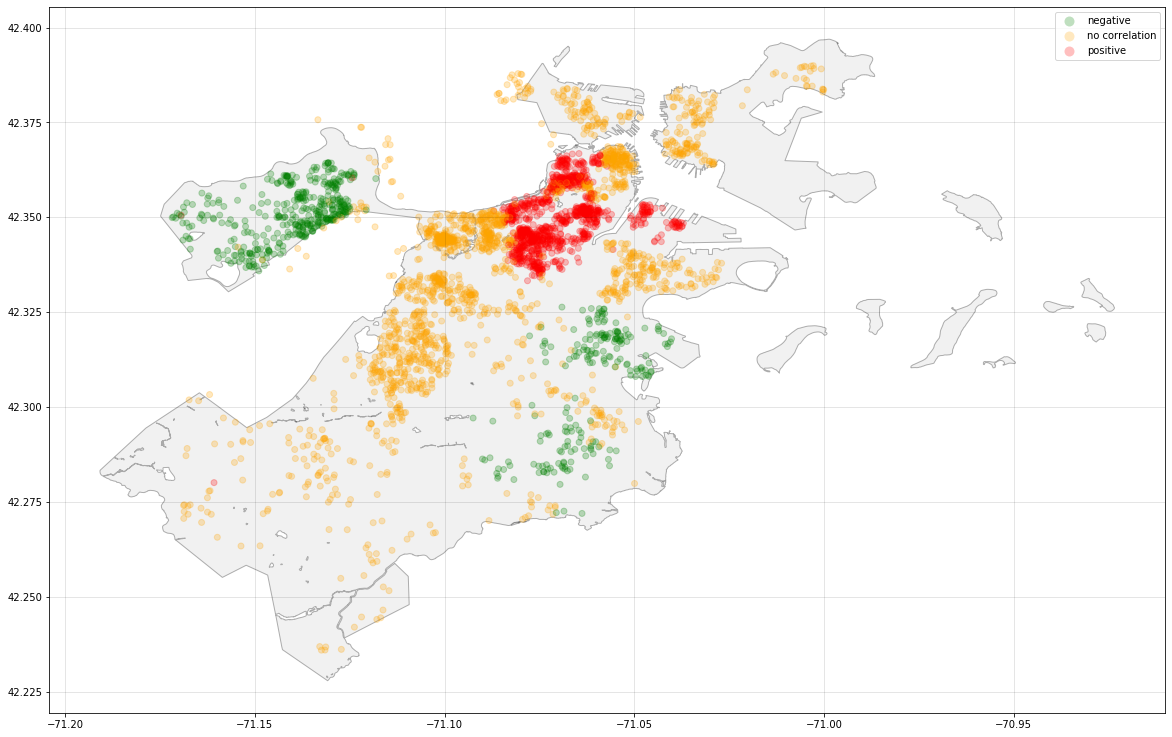

In [72]:
# creating color map for categories
categories = np.unique(b_geo["correlation"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_boston["Color"] = gdf_boston["correlation"].apply(lambda x: colordict[x])

# Create a color map for correlation columns
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "orange","red"])

# Plot listings and colorize them by zip-price-correlation
ax1 = boston.plot(figsize=(20, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax1.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax1.set_facecolor('white')
gdf_boston.plot(ax=ax1, marker='o', alpha=0.25, legend=True, column='correlation', cmap=cmap)
plt.savefig('boston_corr_map.png')

### Seattle

In [73]:
# get zips that correlate positively
positive_correlation_zips = []
for element in positive_correlation_seattle:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        positive_correlation_zips.append(zipcode)
print(positive_correlation_zips)

# get zips that correlate negatively
negative_correlation_zips = []
for element in negative_correlation_seattle:
    if "zipcode_" in element:
        zipcode = element.split("zipcode_")[1]
        negative_correlation_zips.append(zipcode)
print(negative_correlation_zips)
        
# Merge both
correlation_zips = positive_correlation_zips + negative_correlation_zips

['98101']
[]


In [74]:
# Drop NaNs and compare before and after
print(s_df.shape[0])
s_df_corr_zips = s_df.dropna(subset=['zipcode']).reset_index()
print(s_df_corr_zips.shape[0])

3818
3811


In [75]:
# Create correlation columns and write value based correlating zip codes
s_df_corr_zips["correlation"] = None

for i in range(0, s_df_corr_zips.shape[0]):
    if(s_df_corr_zips['zipcode'][i] in positive_correlation_zips):
        s_df_corr_zips["correlation"][i] = "positive"
    elif(s_df_corr_zips['zipcode'][i] in negative_correlation_zips):
        s_df_corr_zips["correlation"][i] = "negative"
    else:
        s_df_corr_zips["correlation"][i] = "no correlation"

# Print unique values and check if everything worked fine    
print(s_df_corr_zips["correlation"].value_counts())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


no correlation    3610
positive           201
Name: correlation, dtype: int64


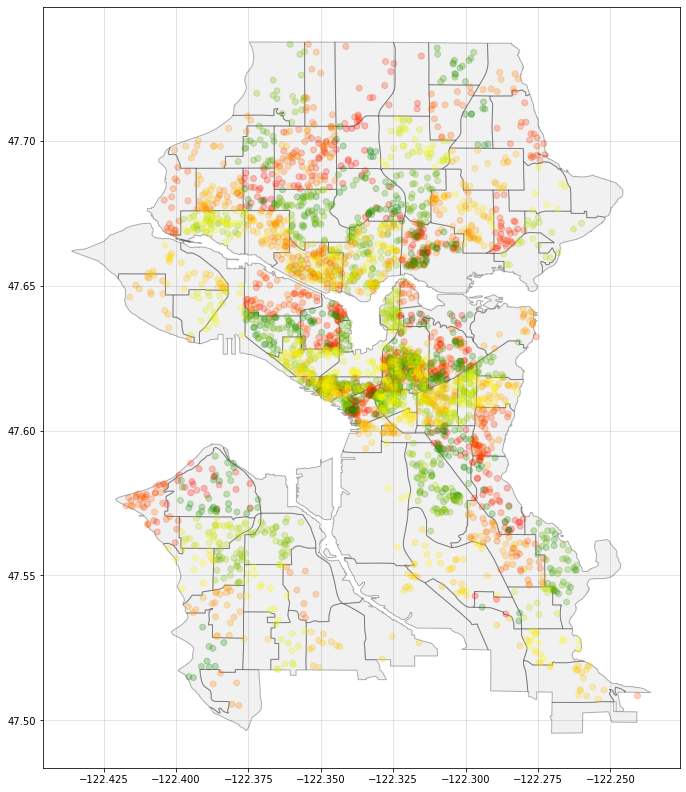

In [76]:
# Create df with only the columns we need
s_geo = s_df_corr_zips[["id", "price", "latitude", "longitude", "correlation"]]

# Create geopandes df
gdf_seattle = geopandas.GeoDataFrame(
    s_geo, geometry=geopandas.points_from_xy(s_geo["longitude"], s_geo["latitude"]))


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
    
# Plot listings and colorize them by prize
ax2 = seattle.plot(figsize=(16, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax2.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax2.set_facecolor('white')
gdf_seattle.plot(ax=ax2, alpha=0.25, c=gdf_seattle["price"], cmap=cmap)
plt.savefig('seattle_price_map.png')

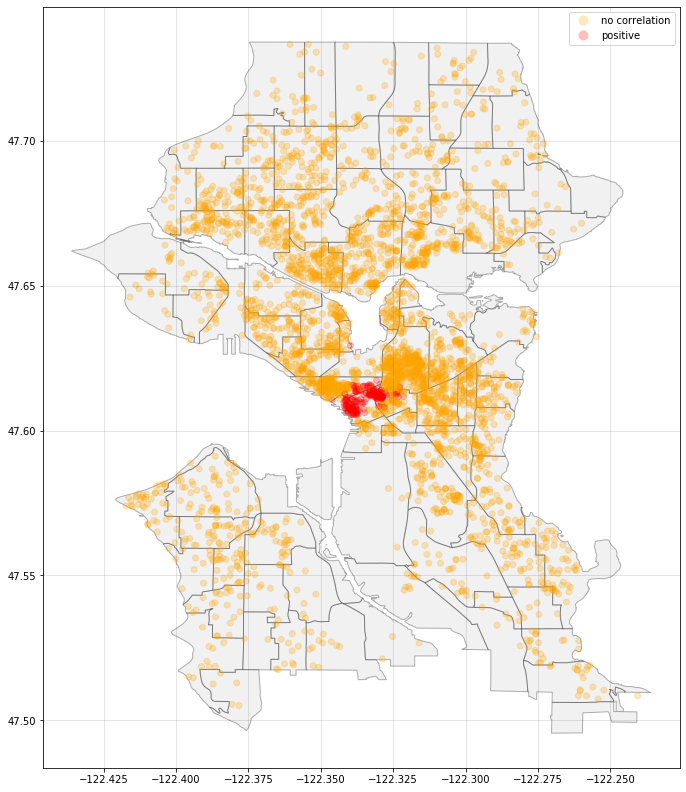

In [77]:
# creating color map for categories
categories = np.unique(s_geo["correlation"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_seattle["Color"] = gdf_seattle["correlation"].apply(lambda x: colordict[x])

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","red"])

# Plot listings and colorize them by zip-price-correlation
ax1 = seattle.plot(figsize=(16, 14), alpha=0.3, edgecolor='black', color='lightgrey')
ax1.grid(color='black', alpha=0.1, linestyle='-', linewidth=1)
ax1.set_facecolor('white')
ax1.legend(b_df_corr_zips['correlation'])
gdf_seattle.plot(ax=ax1, marker='o', alpha=0.25, legend=True, column='correlation', cmap=cmap)

plt.savefig('seattle_corr_map.png')

# Conclusion

## BQ1: 
The results indicate that Airbnb listings for Boston are (in average) more expensive than Seattle. But now it what be interesting what actually influence these listing prices. So let's move ahead to BQ2.

## BQ2:
The results for both cities were very similiar. For example bedrooms, beds, bathrooms and the number of included guests had a positive influence on the price. The number of reviews per month lead to a lower price.

But the models that only used the reduced sets of features performed slightly worse. It would be interesting for future projects to do more feature engineering and to check other methods like XG boost to see if the would perform better.

During the correlation analysis I found out that there were some ZIP codes that correlated positively or negatively with the prices. However, these ZIP codes are only numbers to me. We should plot them on the city maps to get a better understanding of price dynamics.

## BQ3:
For both Boston and Seattle it is not quite obvious which areas lead to high prices. But if we plot the listings and colorize them by zip-price-correlation we see that especially the city centers lead to higher listings prices. For seattle we couldnt find areas that correlate negatively with the price. For boston we found several areas.

Thank you for working through this notebook! I hope you had as much fun as I had.